In [15]:
from typing import Dict
import pandas as pd
import numpy as np
df = pd.read_excel('test_data_s.xlsx')
class Trend:
    req={}
    def __init__(self, type_val, df) -> None:
        self.df = df
        self.type_val = type_val
        Trend.req[type_val] = self
    def __repr__(self) -> str:
        return repr(self.df)
    def get_c00_pick(self):
        return np.polyfit(
            self.df['Нак, млрд.м3'],
            self.df['пик. млн.м3/сут'],
            4)
    def get_c00_prod(self):
        return np.polyfit(
            self.df['Нак, млрд.м3'][:-1],
            self.df['Годовая, млрд.м3'][1:],
            4)
    def calc_pick_by_total(self, total_val_mlrd):
        return sum([
            total_val_mlrd ** (4-idx) * c00
        for idx, c00 in enumerate(self.get_c00_pick())])
    def calc_prod_by_total(self, total_val_mlrd):
        return sum([
            total_val_mlrd ** (4-idx) * c00
        for idx, c00 in enumerate(self.get_c00_prod())])



In [16]:
for type_val, df_t in df.groupby(['type']):
    if type_val != 20 :
        year_pick = df_t.loc[df_t['Тип суточной']=='Максимальная суточная, 1 кв.']
        year_temp = df_t.loc[df_t['Дата'].dt.strftime(r'%d.%m') == '01.01']
        year_prod = (year_temp['Накопленная добыча газа, м3'] - year_temp['Накопленная добыча газа, м3'].shift(1))/(10**9)
        df_new = pd.concat([
            year_prod.reset_index(drop=True).rename('Годовая, млрд.м3'),
            year_pick['Суточная добыча газа, м3'].reset_index(drop=True).rename('пик. млн.м3/сут')/(10**6),
            year_temp['Дата'].reset_index(drop=True).map(lambda x: x.year -1),
            year_temp['Накопленная добыча газа, м3'].reset_index(drop=True).rename('Нак, млрд.м3')/(10**9),
        ],axis=1)
        Trend(bin(type_val), df_new)

In [17]:
sched = {
    2023:'0b001',
    2025:'0b011',
    2027:'0b111',
}
class Shed:
    schema = {
        1 :  '0b1',
        2 : '0b10',
        3 :'0b100'
    }
    req = None
    def __init__(self, year_one, year_two, year_three) -> None:
        self.year_one = year_one
        self.year_two = year_two
        self.year_three = year_three
        Shed.req = self
        self.shedule = {}
        base = 0
        for year in Trend.req['0b0'].df['Дата']:
            self.shedule[year] = base
            if year == year_one:
                base += int(self.schema[1],2)
            if year == year_two:
                base += int(self.schema[2],2)
            if year == year_three:
                base += int(self.schema[3],2)
            self._df = pd.Series({
                key:f'{self.shedule[key]:03b}'
            for key in self.shedule})

        self._res_year_prod = {Trend.req['0b0'].df['Дата'][0]:None}
        nak = Trend.req['0b0'].df['Нак, млрд.м3'][0]
        self._res_year_nak = {Trend.req['0b0'].df['Дата'][0]:nak}
        for idx, year in list(enumerate(self.shedule))[1:]:
            type_val = bin(self.shedule[year])
            year_prod = Trend.req[type_val].calc_prod_by_total(nak)
            nak += year_prod
            self._res_year_prod[year] = year_prod
            self._res_year_nak[year] = nak
        
    @property
    def get_year_prod(self)-> pd.Series:
        return pd.Series(self._res_year_prod)        
    @get_year_prod.setter
    def get_year_prod(self, value):
        #TODO написать пересчет _res_year_nak
        pass
    @property
    def get_year_total(self)-> pd.Series:
        return pd.Series(self._res_year_nak)        
    def __repr__(self) -> str:
        return str(self._df)

t = Shed(2025,2023,2027)
print(
    pd.concat([
        Trend.req['0b0'].df['Дата'].reset_index(drop=True),
        Trend.req['0b0'].df['Годовая, млрд.м3'].reset_index(drop=True).rename('0b0'),
        Trend.req['0b10'].df['Годовая, млрд.м3'].reset_index(drop=True).rename('0b10'),
        Trend.req['0b11'].df['Годовая, млрд.м3'].reset_index(drop=True).rename('0b11'),
        Trend.req['0b111'].df['Годовая, млрд.м3'].reset_index(drop=True).rename('0b111'),
        t._df.reset_index(drop=True),
        t.get_year_prod.reset_index(drop=True),
    ],axis=1))



   Дата        0b0       0b10       0b11      0b111    0          1
0  2021        NaN        NaN        NaN        NaN  000        NaN
1  2022  78.757233  78.757233  78.757233  78.777549  000  78.767233
2  2023  71.180747  71.180747  71.180747  73.881747  000  71.123757
3  2024  59.129987  61.585490  62.064820  65.349878  010  61.870164
4  2025  46.535803  49.903043  52.755562  57.223807  010  49.921299
5  2026  34.790048  38.560334  44.098519  49.974346  011  44.114460
6  2027  24.335745  27.654357  35.541746  42.932765  011  36.498859
7  2028  16.571040  20.960772  30.728782  38.890635  111  41.468162
8  2029  10.959323  16.805659  27.329036  34.270740  111  36.817897


In [20]:
print(t)
pd.concat([
    t.get_year_prod,
    t.get_year_total]
    ,axis=1)


2021    000
2022    000
2023    000
2024    010
2025    010
2026    011
2027    011
2028    111
2029    111
dtype: object


,0,1
2021,NaN,1711.546302
2022,78.767233,1790.313536
2023,71.123757,1861.437293
2024,61.870164,1923.307457
2025,49.921299,1973.228757
2026,44.114460,2017.343217
2027,36.498859,2053.842076
2028,41.468162,2095.310238
2029,36.817897,2132.128136


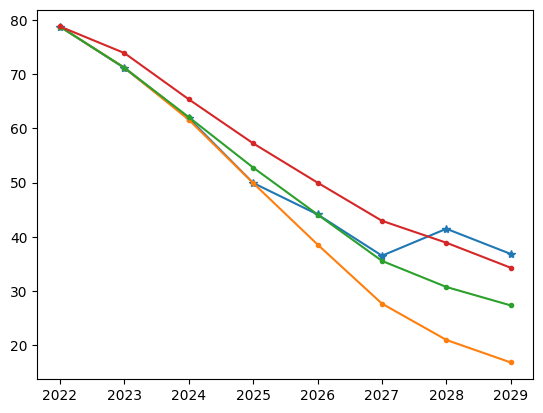

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(t.get_year_prod, marker='*')
# ax.plot(Trend.req['0b0'].df['Дата'],Trend.req['0b0'].df['Годовая, млрд.м3'], marker='*')
ax.plot(Trend.req['0b0'].df['Дата'],Trend.req['0b10'].df['Годовая, млрд.м3'], marker='.')
ax.plot(Trend.req['0b0'].df['Дата'],Trend.req['0b11'].df['Годовая, млрд.м3'], marker='.')
ax.plot(Trend.req['0b0'].df['Дата'],Trend.req['0b111'].df['Годовая, млрд.м3'], marker='.')

plt.show()